# Fundamentos de Deep Learning con PyTorch

## MNIST

<img src="mnist.png">

The predicted class is: 9


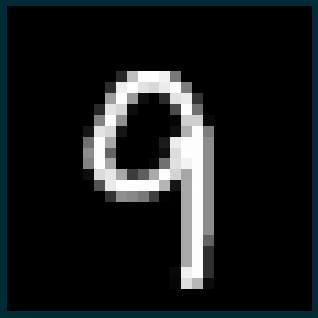

In [14]:
image=sample_number()
_, class_is = loaded_model(image).max(1)
print(f'The predicted class is: {class_is[0]}')

## Importar librerías

In [1]:
# Para graficar
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Las principales de PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
# Otras más de PyTorch
from torch.utils.data import DataLoader #Para dividir nuestros datos
from torch.utils.data import sampler # Para muestrar datos
import torchvision.datasets as dataset # Para importar DataSets
import torchvision.transforms as T # Para aplicar transformaciones a nuestros datos
# No es importante, sólo si tienen Jupyter Themes. Nothing to do with Deep Learning
from jupyterthemes import jtplot
jtplot.style()


    

## Importar MNIST Dataset

In [2]:
NUM_TRAIN = 55000
BATCH_SIZE = 512

# Get our training, validation and test data.
# data_path = '/media/josh/MyData/Databases/' #use your own data path, you may use an existing data path to avoid having to download the data again.
data_path = '/media/josh/MyData/Databases/mnist'
mnist_train = dataset.MNIST(data_path, train=True, download=True,
                             transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=BATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

mnist_val = dataset.MNIST(data_path, train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=BATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 60000)))

mnist_test = dataset.MNIST(data_path, train=False, download=True, 
                            transform=T.ToTensor())
loader_test = DataLoader(mnist_test, batch_size=BATCH_SIZE)

### Cómo usar un DataLoader?

Un [DataLoader](https://pytorch.org/docs/stable/data.html) de PyTorch es un objeto Iterable de Python, sobre nuestro Dataset!



In [ ]:
len(y_test)

In [3]:
y_test=loader_test.dataset.targets
x_test=loader_test.dataset.data
print(y_test.shape)
print(x_test.shape)

torch.Size([10000])
torch.Size([10000, 28, 28])


In [ ]:
for it, (x, y) in enumerate(loader_test):
    print(f'{it} X.shape is {x.shape}, y.shape is {y.shape}')

In [ ]:
input_features = len(torch.flatten(x_test[0]))
input_features

In [4]:
def plot_number(image):
    jtplot.style(grid=False)
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
#     plt.show()
    plt.axis('off')
    jtplot.style(grid=True)

In [ ]:
def plot_mnist_grid():
    y_test=loader_test.dataset.targets
    x_test=loader_test.dataset.data
    samples = 8
    plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
    classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    for label, example in enumerate(classes):
    #     random_idx = np.random.randint(0,len(mnist_test))
        plt_idxs = np.flatnonzero(y_test == label) # get all data equal to label
        plt_idxs = np.random.choice(plt_idxs, samples, replace=False) #muestrea samples muestras de plt_idx
    #     print(plt_idxs)
        for i, idx in enumerate(plt_idxs):
            plt_idx = i*len(classes) + label + 1 #plot index starts at 1
            plt.subplot(samples, len(classes), plt_idx)
    #         print(example, i, plt_idx)
    #         plt.imshow(x_test[idx].type(torch.float32).reshape(28,28))
    #         plt.axis('off')
            plot_number(x_test[idx])
            if i == 0:
                plt.title(example)

    plt.show()
plot_mnist_grid()

In [ ]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx]}')
plot_number(x_test[rnd_idx])

## GPUs

In [5]:
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Compute Accuracy

In [ ]:
def compute_acc(loader, model, eval_mode=False):
    num_correct = 0
    num_total = 0
    if eval_mode: model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, pred = scores.max(1)
            assert pred.shape == y.shape, 'Label shape and prediction shape does not match'
            num_correct += (pred==y).sum()
            num_total += pred.size(0)           
            
        return float(num_correct)/num_total

## High level model

In [ ]:
input_features = len(torch.flatten(x_test[0]))
hidden = 1000
num_classes = 10

In [ ]:
model1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=input_features, out_features=hidden),
    nn.ReLU(),
    nn.Linear(in_features=hidden, out_features=num_classes),
    )

In [ ]:
def plot_loss(losses):  
    fig = plt.figure()
    f1 = fig.add_subplot()
    f1.set_ylabel("Cost")
    f1.set_xlabel("Epoch")
    f1.set_title("Cost vs Epoch")
    f1.plot(losses)
    plt.show()
    
def train(model, optimizer, epochs=100):
    model = model.to(device=device)
    losses = []
    
    num_batches = len(loader_train)
    for epoch in range(epochs):
        accum_loss = 0.
        for i, (x, y) in enumerate(loader_train):
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            #calcular scores
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            
            #calcular gradients
            optimizer.zero_grad()
            cost.backward()
            
            #actualizar parametros
            optimizer.step()
            
            #guardar pérdida
            accum_loss += cost.item()
        losses.append(accum_loss / num_batches)
            
        print(f'Epoch: {epoch}, loss: {cost.item()}, val accuracy: {compute_acc(loader_val, model, True)} ')
        print()
    plot_loss(losses)

In [ ]:
learning_rate = 1e-2
epochs = 10
optimiser = torch.optim.SGD(model1.parameters(), lr=learning_rate)
train(model1, optimiser, epochs)

## More elegant high level model

In [6]:
class FC_model(nn.Module):
    def __init__(self, input_features, hidden = 1000, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_features, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=num_classes),
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
input_features = len(torch.flatten(x_test[0]))
hidden = 1000
num_classes = 10
learning_rate = 1e-2
epochs = 10
model2 = FC_model(input_features)
optimiser = torch.optim.Adam(model2.parameters(), lr = learning_rate)
# optimiser = torch.optim.SGD(model2.parameters(), lr = learning_rate)
train(model2, optimiser, epochs)

In [ ]:
compute_acc(loader_test, model2)

## Guardando el modelo

In [7]:
model_path = '/media/josh/MyData/Databases/mnist/FC_model1st.pth'

In [ ]:
torch.save(model2.state_dict(), model_path)

In [8]:
input_features = len(torch.flatten(x_test[0]))
loaded_model = FC_model(input_features=input_features)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model = loaded_model.to(device=device)
loaded_model.eval()

FC_model(
  (model): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=1000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=10, bias=True)
  )
)

In [9]:
def sample_number():
    rnd_idx = np.random.randint(10000)
#     print(f'{y_test[rnd_idx]}')
    image2 = x_test[rnd_idx][None, :,:]
    plot_number(image2)
    image2 = image2.type(torch.float32)
    return image2.to(device=device)

In [ ]:
image=sample_number()
_, class_is = loaded_model(image).max(1)
print(f'The predicted class is: {class_is[0]}')

## Red Neuronal con módulos básicos

In [ ]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

In [ ]:
class FC_other():
    def __init__(self, in_features, hidden=1000, num_classes = 10):
        self.W1 = torch.randn((in_features, hidden), device=device, dtype=dtype) * np.sqrt(2/in_features)
        self.W1.requires_grad = True
        self.b1 = torch.zeros((hidden), device=device, dtype=dtype)
        self.b1.requires_grad = True
        
        self.W2 = torch.randn((hidden, num_classes), device=device, dtype=dtype) * np.sqrt(2/in_features)
        self.W2.requires_grad = True
        self.b2 = torch.zeros((num_classes), device=device, dtype=dtype)
        self.b2.requires_grad = True
        
#     def forward(self, x):
    def __call__(self, x):
        x = flatten(x)
        x = x @ self.W1 + self.b1
        x = F.relu(x)
        return x @ self.W2 + self.b2

                

In [ ]:
sample1 = x_test[0][None, :, :].to(device=device, dtype=dtype)

In [ ]:
input_features

In [ ]:
hidden = 1000
num_classes = 10
model3 = FC_other(input_features, hidden, num_classes)
# print(model3.forward(sample1).shape)
print(model3(sample1).shape)

In [ ]:
def train_loop(model, epochs=10, learning_rate = 1e-6):
#     model = model.to(device=device)
    losses = []
    num_batches = len(loader_train)
    for epoch in range(epochs):
        acum_loss = 0.
        for it, (x, y) in enumerate(loader_train):
            #Move to selected device
            x=x.to(device=device, dtype=dtype)
            y=y.to(device=device, dtype=torch.long)
#             print(x.shape)
            #compute scores
#             scores = model.forward(x)
            scores = model(x)
            #compute cost
            cost = F.cross_entropy(input=scores, target=y)
            #compute gradient
            cost.backward()
            
            #update parameters
            with torch.no_grad():
                model.W1 -= learning_rate * model.W1.grad
                model.b1 -= learning_rate * model.b1.grad
                
                model.W2 -= learning_rate * model.W2.grad
                model.b2 -= learning_rate * model.b2.grad
                
                #zero grads
                model.W1.grad.zero_()
                model.b1.grad.zero_()
                model.W2.grad.zero_()
                model.b2.grad.zero_()            
            
            acum_loss += cost.item()
        losses.append(acum_loss/num_batches)
        print(f'Epoch: {epoch}, loss: {cost.item()}, val accuracy: {compute_acc(loader_val, model)} ')
        print()
            

In [ ]:
learning_rate = 1e-2
epochs = 20
hidden = 1000
num_classes = 10
model_fc1 = FC_other(input_features, hidden, num_classes)
# print(model_fc1.forward(x1).shape)

train_loop(model_fc1, epochs, learning_rate)